<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-science-bookcamp/case-study-5--predicting-future-friendships/02_dynamic_graph_theory_and_social_network_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dynamic graph theory for node ranking and social network analysis

Network theory is the study of connections between objects. These objects can be
anything: 

* people connected by relationships, 
* web pages connected by web links, or
* cities connected by roads. 

A collection of objects and their dispersed connections is
called either a network or a graph, depending on whom you ask. 

Engineers prefer to use the term network, while mathematicians prefer graph.

Graphs are simple abstractions that
capture the complexity of our entangled, interconnected world. 

Properties of graphs
remain surprisingly consistent across systems in society and nature.

Graph theory is a
framework for mathematically tracking these consistencies. It combines ideas from diverse branches of mathematics, including probability theory and matrix analysis.

These ideas can be used to gain useful real-world insights ranging from:

* search engine page rankings 
* social circle clustering

So some knowledge of graph theory is indispensable to doing good data science.

##Setup

In [1]:
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import re
import glob
import time
import numpy as np
import pandas as pd

import networkx as nx

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

##Modeling complex network

In [4]:
# Modeling five towns in the same county
G = nx.Graph()
G.add_nodes_from((i, {"county_id": 0}) for i in range(5))

In [5]:
# Modeling random intra-county roads
def add_random_edge(G, node1, node2, prob_road=.9, mean_drive_time=20):
  # Flips a coin to determine whether an edge is inserted
  if np.random.binomial(1, prob_road):
    # Chooses the travel time from a normal distribution  
    drive_time = np.random.normal(mean_drive_time)
    G.add_edge(node1, node2, travel_time=round(drive_time, 2))

def random_county(county_id):
  # Chooses the number of towns in the county at random from an integer range of 3 to 10
  num_towns = np.random.randint(3, 10)
  G = nx.Graph()
  nodes = [(node_id, {"county_id": county_id}) for node_id in range(num_towns)]
  G.add_nodes_from(nodes)
  for node1, _ in nodes[:-1]:
    for node2, _ in nodes[node1 + 1:]:
      add_random_edge(G, node1, node2)
  return G

def add_intercounty_edges(G):
  nodes = list(G.nodes(data=True))
  # Iterates over every node and Iterates over every node and
  for node1, attributes1 in nodes[:-1]:
    county1 = attributes1["county_id"]
    # Iterates over node pairs that we have not yet compared
    for node2, attributes2 in nodes[node1:]:
      if county1 != attributes2["county_id"]:
        add_random_edge(G, node1, node2, prob_road=0.05, mean_drive_time=45)
  return G

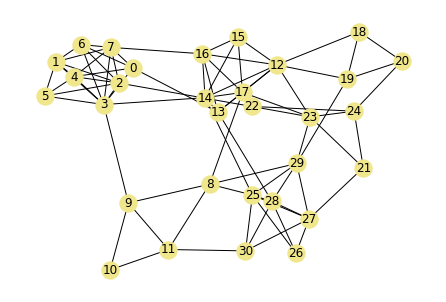

In [6]:
# Simulating six interconnected counties
np.random.seed(1)

G = random_county(0)
for county_id in range(1, 6):
  G2 = random_county(county_id)
  G = nx.disjoint_union(G, G2) 

G = add_intercounty_edges(G)
np.random.seed(1)
nx.draw(G, with_labels=True, node_color="khaki")
plt.show()

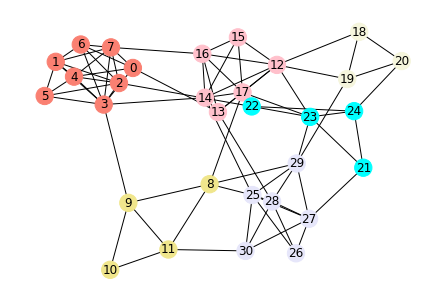

In [7]:
# Coloring nodes by county
np.random.seed(1)

county_colors = ['salmon', 'khaki', 'pink', 'beige', 'cyan', 'lavender']
county_ids = [G.nodes[n]["county_id"] for n in G.nodes]
node_colors = [county_colors[id_] for id_ in county_ids] 

nx.draw(G, with_labels=True, node_color=node_colors)
plt.show()

##Uncovering central nodes

Suppose our business is growing at an impressive rate. We wish to expand our customer
base by putting up a billboard advertisement in one of the local towns represented
by `G.nodes`. 

To maximize billboard views, we’ll choose the town with the
heaviest traffic.

Using simple modeling, we can predict traffic flow from the
network of roads between the towns.

We can compute the degree of any node i by summing over the ith column of the
graph’s adjacency matrix, or we can measure the degree by running `len(G.nodes[i])`.

In [8]:
# Computing the degree of a single node
adjacency_matrix = nx.to_numpy_array(G)
degree_town_0 = adjacency_matrix[:, 0].sum()
assert degree_town_0 == len(G[0])
assert degree_town_0 == G.degree(0)

print(f"Town 0 is connected by {degree_town_0:.0f} roads.")

Town 0 is connected by 5 roads.


Using their degrees, we rank our nodes based on importance. 

In graph theory, any
measure of a node’s importance is commonly called node centrality, and ranked importance
based on a node’s degree is called the degree of centrality. 

We now select the node
with the highest degree of centrality in G: this central node will serve as our initial
choice for the billboard’s location.

Town 3 is our most central town. It has 9 connecting roads.


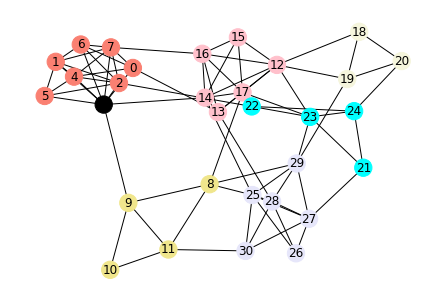

In [9]:
# Selecting a central node using degree of centrality
np.random.seed(1)

central_town = adjacency_matrix.sum(axis=0).argmax()
degree = G.degree(central_town)
print(f"Town {central_town} is our most central town. It has {degree} connecting roads.")

node_colors[central_town] = "k"
nx.draw(G, with_labels=True, node_color=node_colors)
plt.show()

In [10]:
# Selecting a node with the second-highest degree of centrality
second_town = sorted(G.nodes, key=lambda x: G.degree(x), reverse=True)[1]
second_degree = G.degree(second_town)
print(f"Town {second_town} has {second_degree} connecting roads.")

Town 12 has 8 connecting roads.


What would we do if these two towns had equal degrees? 

Let’s challenge ourselves to find out.

Suppose that road is closed due to disrepair. That closure necessitates the removal of an edge in G.


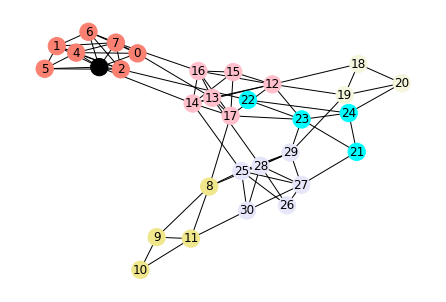

In [11]:
# Removing an edge from the most central node
np.random.seed(1)

G.remove_edge(3, 9)
# After edge deletion, Towns 3 and 12 share the same degree of centrality
assert G.degree(3) == G.degree(12)

nx.draw(G, with_labels=True, node_color=node_colors)
plt.show()

Town 3 is now less central than Town 12, but the degrees of both towns are equal.

We’ve exposed a significant flaw of the degree of centrality: connecting roads don’t matter if they don’t lead anywhere important.

###Measuring nodes centrality

We’ll shortly simulate traffic in our network by having 20,000 simulated cars drive randomly
around our 31 towns. 

However, first we need to simulate the random path of a
single car.

>In graph theory, this type of random traversal between nodes is called
a random walk.

In [12]:
# Simulating the random route of a single car
np.random.seed(0)

def random_drive(num_stops=10):
  # The car’s starting location is chosen at random
  town = np.random.choice(G.nodes)
  for _ in range(num_stops):
    # The car drives to a random neighboring town
    town = np.random.choice(G[town])
  return town

In [13]:
destination = random_drive()
print(f"After driving randomly, the car has reached Town {destination}.")

After driving randomly, the car has reached Town 24.


In [14]:
# Simulating traffic using 20,000 cars
np.random.seed(0)

car_counts = np.zeros(len(G.nodes))
num_cars = 20000

start_time = time.time()

for _ in range(num_cars):
  destination = random_drive()
  car_counts[destination] += 1

central_town = car_counts.argmax()
traffic = car_counts[central_town]
running_time = time.time() - start_time

print(f"We ran a {running_time:.2f} second simulation.")
print(f"Town {central_town} has the most traffic.")
print(f"There are {traffic:.0f} cars in that town.")

We ran a 5.34 second simulation.
Town 12 has the most traffic.
There are 1015 cars in that town.


This is not surprising, given that
Town 12 and Town 3 share the highest degree of centrality. 

Based on our previous discussion,
we also expect Town 12 to have heavier traffic than Town 3.

In [15]:
# Checking the traffic in Town 3
print(f"There are {car_counts[3]:.0f} cars in Town 3.")

There are 934 cars in Town 3.


Our expectations are verified. Town 3 has fewer than 1000 cars. 

We should note that
car counts can be cumbersome to compare, especially when `num_cars` is large. 

Hence, it’s preferable to replace these direct counts with probabilities through division by the
simulation count.

In [16]:
# Converting traffic counts to probabilities
probabilities = car_counts / num_cars

for i in [12, 3]:
  prob = probabilities[i]
  print(f"The probability of winding up in Town {i} is {prob:.3f}")

The probability of winding up in Town 12 is 0.051
The probability of winding up in Town 3 is 0.047


Unfortunately, our simulation process is slow and doesn’t scale well to
larger graphs.

Can we compute these probabilities directly without simulating the flow of 20,000 cars? Yes!

We can compute the traffic probabilities using
straightforward matrix multiplication.

##Computing travel probabilities

Our traffic simulation can be modeled mathematically using matrices and vectors.

In [18]:
# Computing the probability of travel to a neighboring town
num_neighbors = G.degree(0)
prob_travel = 1 / num_neighbors
print(f"The probability of traveling from Town 0 to one of its {G.degree(0)} neighboring towns is {prob_travel}")

The probability of traveling from Town 0 to one of its 5 neighboring towns is 0.2


In [19]:
# Computing a transition vector
transition_vector = np.array([0.2 if i in G[0] else 0 for i in G.nodes])

# Recomputes the adjacency matrix to take into account our earlier edge deletion
adjacency_matrix = nx.to_numpy_array(G)
v2 = np.array([1 if i in G[0] else 0 for i in G.nodes]) * .2
v3 = adjacency_matrix[:, 0] * .2
# Computes the transition vector directly from the adjacency matrix column
v4 = adjacency_matrix[:, 0] / adjacency_matrix[:, 0].sum()

# All four computed versions of the transition vector are identical
for v in [v2, v3, v4]:
  assert np.array_equal(transition_vector, v)

print(transition_vector)

[0.  0.  0.  0.2 0.2 0.  0.2 0.2 0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]


The operation divides each column of the
adjacency matrix by the associated degree. The end result is a matrix whose columns
correspond to transition vectors. 

This matrix is
referred to as a transition matrix. It is also commonly called the Markov matrix.

In [21]:
# Computing a transition matrix
transition_matrix = adjacency_matrix / adjacency_matrix.sum(axis=0)
assert np.array_equal(transition_vector, transition_matrix[:, 0])

Our transition matrix has a fascinating property: it allows us to compute the traveling
probability to every town in just a few lines of code!


In [22]:
# Computing travel probabilities using the transition matrix
v = np.ones(31) / 31
for _ in range(10):
  v = transition_matrix @ v

for i in [12, 3]:
  print(f"The probability of winding up in Town {i} is {v[i]:.3f}")

The probability of winding up in Town 12 is 0.051
The probability of winding up in Town 3 is 0.047


We can model traffic flow using a series of matrix multiplications. These multiplications
serve as the basis for PageRank centrality, which is the most profitable nodeimportance
measure in history. 

PageRank centrality was invented by the founders of
Google; they used it to rank web pages by modeling a user’s online journey as a series
of random clicks through the internet’s graph.

PageRank centrality is easy to compute but not so easy to derive. Nonetheless, with
basic probability theory, we can demonstrate why repeated `transition_matrix` multiplications
directly yield the travel probabilities.

###PageRank with probability theory